# Polygon drill

**What does this notebook do?** 

This notebook pulls in data based on the extent of a provided polygon. The polygon is then used to mask the data. 

**Required inputs** 

* A shape file containing the polygon you would like to use for the analysis. Here we use the ACT state boundary, available as a [shapefile from data.gov.au](https://data.gov.au/dataset/act-state-boundary-psma-administrative-boundaries/resource/20cc8694-1ac0-4c5c-bc5f-7710089d824a). 

This example uses a function called `three_band_image`. This function is available within the `DEAPlotting.py` file in the `Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date** May 2018

**Author** Claire Krause

In [1]:
%matplotlib inline

from datacube import Datacube
from datacube.utils import geometry
import fiona
import rasterio.features

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import DEAPlotting

dc = Datacube(app = 'Polygon drill')

Populating the interactive namespace from numpy and matplotlib


Failed to resolve driver datacube.plugins.index::s3aio_index


## Import our shapefile with Fiona, and grab its `geometry` for the DEA extraction query

In [2]:
shape_file = os.path.expanduser('~/dea-notebooks/Scripts/ACT_STATE_POLYGON_shp.shp')

In [3]:
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

## Set up the extraction query

**Note** We are pulling the data in using their native resolution (Landsat ~25m, Sentinel ~10m), so our data will have different numbers of pixels for the same area.

In [4]:
query = {'geopolygon': geom,
         'time': ('2016-01-01', '2016-06-30')
         }

## Load in the data from Landsat 8 using our polygon to set the extent

In [5]:
data = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)

Failed to resolve driver datacube.plugins.io.read::s3aio
Failed to resolve driver datacube.plugins.io.read::s3aio_test


In [6]:
data

<xarray.Dataset>
Dimensions:          (time: 23, x: 2465, y: 3472)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-05T23:50:22 ...
  * y                (y) float64 -3.94e+06 -3.94e+06 -3.94e+06 -3.94e+06 ...
  * x                (x) float64 1.513e+06 1.513e+06 1.513e+06 1.513e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 4079 4213 4546 4997 5165 5229 5516 ...
    blue             (time, y, x) int16 3892 4010 4324 4760 4969 5013 5248 ...
    green            (time, y, x) int16 3705 3857 4200 4586 4767 4869 5229 ...
    red              (time, y, x) int16 3745 3896 4258 4688 4904 5008 5353 ...
    nir              (time, y, x) int16 4546 4684 5041 5475 5663 5701 5989 ...
    swir1            (time, y, x) int16 3141 3279 3591 3943 4087 4222 4611 ...
    swir2            (time, y, x) int16 2325 2410 2659 2930 3074 3159 3511 ...
Attributes:
    crs:      EPSG:3577

<div class="alert alert-info">
Although we have used a polygon for our import, the extent of the returned data is a rectangle with the extents set by the input polygon, not a dataset with areas outside of the polygon set to `NaN`. In this instance, we only want to deal with data inside of our polygon, so we will use it to mask the returned dataset.
</div>

## Mask the dataset with our original polygon to remove extra data

This code creates a mask from the polygons in the input shapefile

In [7]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
dataMasked = data.where(mask)

## Check our polygon has been imported properly

<IPython.core.display.Javascript object>


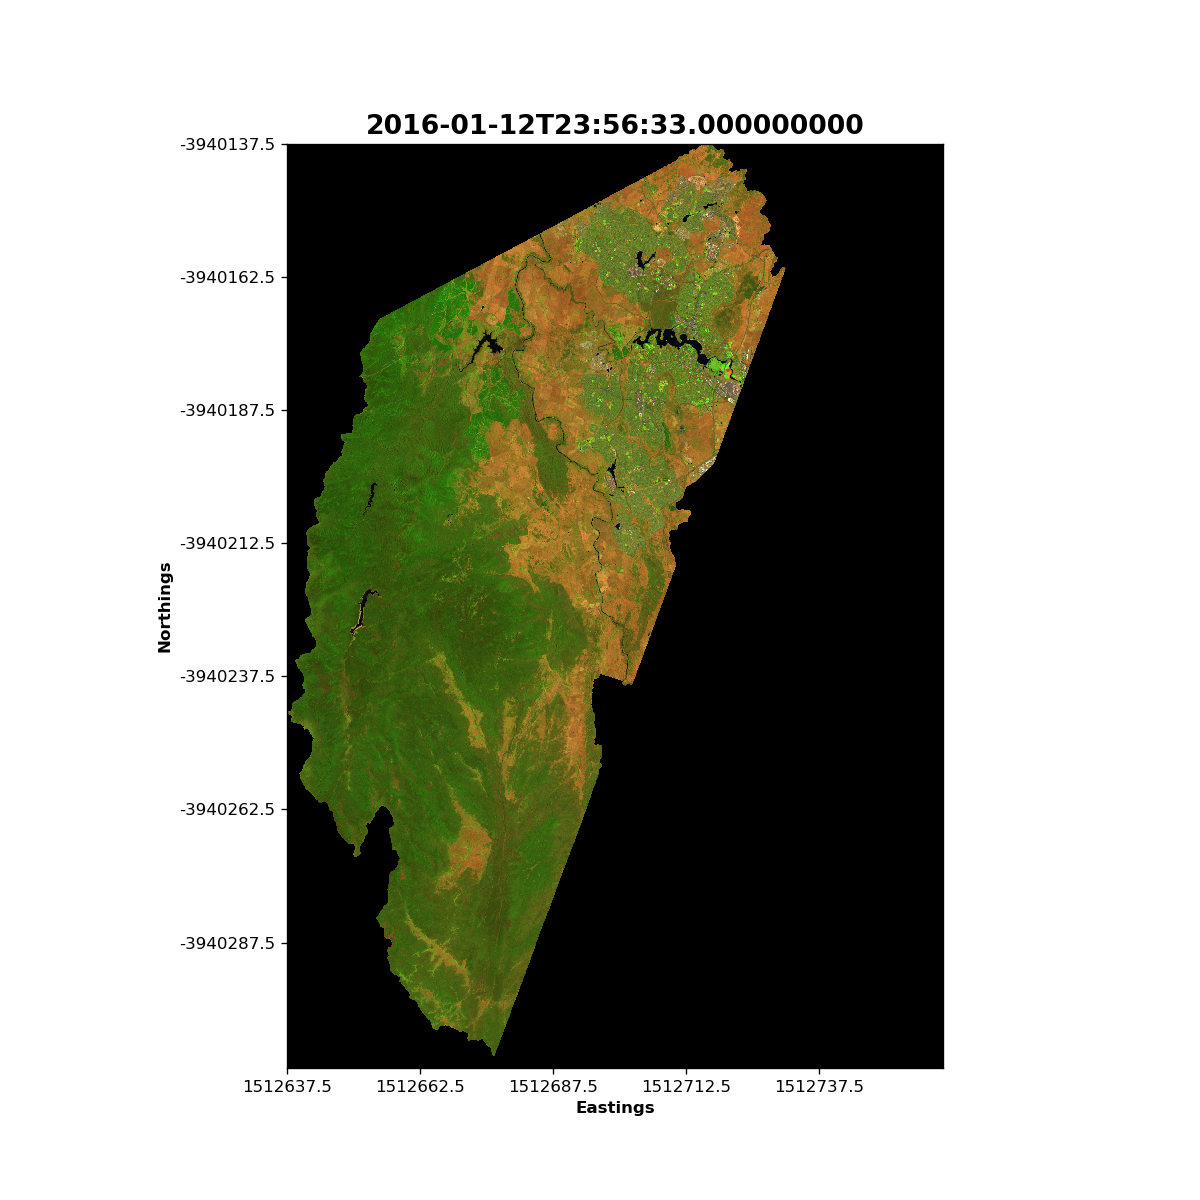

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [8]:
DEAPlotting.three_band_image(dataMasked, bands = ['swir1', 'nir', 'green'], time = 1);